In [1]:
from sklearn.preprocessing import StandardScaler
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
import pandas as pd
import numpy as np

In [2]:
train_word_glove_attention = pd.read_csv('final_features/word_attention_glove/train_predictions.csv')
test_word_glove_attention = pd.read_csv('final_features/word_attention_glove/test_predictions.csv')

train_roberta_512 = pd.read_csv('final_features/512_RoBERTa_attention/train_predictions.csv')
test_roberta_512 = pd.read_csv('final_features/512_RoBERTa_attention/test_predictions.csv')

train_longformer_period = pd.read_csv('final_features/period_longformer_att/train_predictions.csv')
test_longformer_period = pd.read_csv('final_features/period_longformer_att/test_predictions.csv')

train_gemini_period = pd.read_csv('final_features/gemini_attention/train_predictions.csv')
test_gemini_period = pd.read_csv('final_features/gemini_attention/test_predictions.csv')
train_gemini_period.drop(['PeriodID'], axis=1, inplace=True)
test_gemini_period.drop(['PeriodID'], axis=1, inplace=True)

train_time_features = pd.read_csv('final_features/time_series/train_time_features.csv')
test_time_features = pd.read_csv('final_features/time_series/test_time_features.csv')

In [3]:
def merge_model_predictions(model_predictions_dict, is_train=True):
    """
    Merge predictions from different models into a single DataFrame.
    
    Args:
        model_predictions_dict: Dictionary with model names as keys and prediction DataFrames as values
        is_train: Boolean indicating if this is training data
    
    Returns:
        Merged DataFrame with predictions from all models
    """
    merge_cols = ['ID']
    if is_train:
        merge_cols.append('EventType')
    
    # Start with the first DataFrame
    first_model_name = list(model_predictions_dict.keys())[0]
    merged_df = model_predictions_dict[first_model_name]
    
    # Merge with remaining DataFrames
    for model_name in list(model_predictions_dict.keys())[1:]:
        merged_df = pd.merge(
            merged_df,
            model_predictions_dict[model_name],
            on=merge_cols,
            how='inner'
        )
    
    return merged_df


train_predictions = {
    'word_glove_attention': train_word_glove_attention,
    'roberta_512': train_roberta_512,
    'longformer_period': train_longformer_period,
    'gemini_period': train_gemini_period
}

train_models = merge_model_predictions(train_predictions, is_train=True)

test_predictions = {
    'word_glove_attention': test_word_glove_attention,
    'roberta_512': test_roberta_512,
    'longformer_period': test_longformer_period,
    'gemini_period': test_gemini_period
}

test_models = merge_model_predictions(test_predictions, is_train=False)

In [4]:
columns_to_transform = ['tweet_count', 'rolling_mean_tweets', 'rolling_std_tweets', 'relative_frequency', 'tweet_momentum']
train_time_features[columns_to_transform] = train_time_features[columns_to_transform].apply(lambda x: np.log1p(x))
test_time_features[columns_to_transform] = test_time_features[columns_to_transform].apply(lambda x: np.log1p(x))

train_time_features.drop(['EventType'], axis=1, inplace=True)

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def prepare_data(word_glove_df, time_features_df):
    """Merge dataframes for training/prediction."""
    merged_df = pd.merge(
        word_glove_df,
        time_features_df,
        on=['ID', 'PeriodID'],
        how='inner'
    )
    return merged_df

def split_data(train_df, val_size=0.2):
    """Split data based on unique matches."""
    unique_matches = train_df['MatchID'].unique()
    train_idx, val_idx = train_test_split(
        np.arange(len(unique_matches)),
        test_size=val_size,
        random_state=42
    )
    
    train_matches = unique_matches[train_idx]
    val_matches = unique_matches[val_idx]
    
    train_data = train_df[train_df['MatchID'].isin(train_matches)]
    val_data = train_df[train_df['MatchID'].isin(val_matches)]
    
    return train_data, val_data

def apply_pca_transform(data, n_components=None, pca_model=None, scaler=None):
    """Apply PCA transformation to the dataset."""
    # Define columns to exclude
    exclude_cols = ['ID', 'MatchID', 'PeriodID', 'EventType']
    feature_cols = [col for col in data.columns if col not in exclude_cols]
    
    # Extract features
    X = data[feature_cols].copy()
    X = X.fillna(X.mean())
    
    # Fit or transform with scaler
    if scaler is None:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
    else:
        X_scaled = scaler.transform(X)
    
    # Fit or transform with PCA
    if pca_model is None:
        if n_components is None:
            n_components = len(feature_cols)
        pca_model = PCA(n_components=n_components)
        X_pca = pca_model.fit_transform(X_scaled)
        
        # Print variance explained
        cumulative_variance = np.cumsum(pca_model.explained_variance_ratio_)
        print("\nExplained variance ratio by components:")
        for i, var in enumerate(pca_model.explained_variance_ratio_):
            print(f"PC{i+1}: {var:.4f} ({cumulative_variance[i]:.4f} cumulative)")
    else:
        X_pca = pca_model.transform(X_scaled)
    
    # Create DataFrame with PCA results
    pca_cols = [f'PC{i+1}' for i in range(X_pca.shape[1])]
    pca_df = pd.DataFrame(X_pca, columns=pca_cols, index=data.index)
    
    # Add back excluded columns if needed
    for col in exclude_cols:
        if col in data.columns:
            pca_df[col] = data[col]
    
    return pca_df, pca_model, scaler

def train_tabnet_model(train_data, val_data):
    """Train TabNet model."""
    # Define feature columns (now PC components)
    feature_cols = [col for col in train_data.columns 
                   if col.startswith('PC')]
    
    # Prepare data (already scaled during PCA)
    X_train = train_data[feature_cols].values
    y_train = train_data['EventType'].values
    X_val = val_data[feature_cols].values
    y_val = val_data['EventType'].values
    
    # Convert to float32 for PyTorch
    X_train = X_train.astype(np.float32)
    X_val = X_val.astype(np.float32)
    
    # Initialize TabNet classifier
    clf = TabNetClassifier(
        n_d=16,
        n_a=16,
        n_steps=3,
        gamma=1.3,
        n_independent=2,
        n_shared=2,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2e-2),
        scheduler_params=dict(
            mode="min",
            patience=5,
            min_lr=1e-5,
            factor=0.5,
        ),
        scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
        mask_type="entmax",
        verbose=1
    )
    
    # Train the model
    clf.fit(
        X_train=X_train,
        y_train=y_train,
        eval_set=[(X_val, y_val)],
        max_epochs=200,
        patience=20,
        batch_size=32,
    )
    
    return clf, feature_cols

def create_submission(test_word_glove_df, test_time_features_df, model, pca_model, scaler):
    """Create submission dataframe with predictions."""
    # Prepare test data
    test_df = prepare_data(test_word_glove_df, test_time_features_df)
    
    # Apply PCA transformation
    test_pca_df, _, _ = apply_pca_transform(
        test_df, 
        pca_model=pca_model, 
        scaler=scaler
    )
    
    # Get feature columns
    feature_cols = [col for col in test_pca_df.columns if col.startswith('PC')]
    X_test = test_pca_df[feature_cols].values.astype(np.float32)
    
    # Make predictions
    preds = model.predict(X_test)
    pred_proba = model.predict_proba(X_test)
    
    # Create submission dataframe
    submission_df = pd.DataFrame({
        'ID': test_df['ID'],
        'EventType': preds
    })
    
    return submission_df, pred_proba



Explained variance ratio by components:
PC1: 0.5879 (0.5879 cumulative)
PC2: 0.1119 (0.6998 cumulative)
PC3: 0.0521 (0.7519 cumulative)
PC4: 0.0375 (0.7894 cumulative)
PC5: 0.0365 (0.8259 cumulative)
PC6: 0.0278 (0.8537 cumulative)
PC7: 0.0265 (0.8801 cumulative)
PC8: 0.0162 (0.8963 cumulative)
PC9: 0.0141 (0.9104 cumulative)
PC10: 0.0113 (0.9217 cumulative)


/opt/anaconda3/envs/pytorch/lib/python3.11/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.59353 | val_0_auc: 0.85954 |  0:00:00s
epoch 1  | loss: 0.41711 | val_0_auc: 0.89126 |  0:00:00s
epoch 2  | loss: 0.40125 | val_0_auc: 0.8892  |  0:00:00s
epoch 3  | loss: 0.3992  | val_0_auc: 0.88135 |  0:00:00s
epoch 4  | loss: 0.38566 | val_0_auc: 0.88951 |  0:00:00s
epoch 5  | loss: 0.39988 | val_0_auc: 0.87853 |  0:00:01s
epoch 6  | loss: 0.38881 | val_0_auc: 0.89633 |  0:00:01s
epoch 7  | loss: 0.37532 | val_0_auc: 0.90287 |  0:00:01s
epoch 8  | loss: 0.37532 | val_0_auc: 0.90101 |  0:00:01s
epoch 9  | loss: 0.36058 | val_0_auc: 0.89437 |  0:00:01s
epoch 10 | loss: 0.36013 | val_0_auc: 0.90487 |  0:00:02s
epoch 11 | loss: 0.35383 | val_0_auc: 0.89787 |  0:00:02s
epoch 12 | loss: 0.36554 | val_0_auc: 0.89502 |  0:00:02s
epoch 13 | loss: 0.34495 | val_0_auc: 0.89911 |  0:00:02s
epoch 14 | loss: 0.32511 | val_0_auc: 0.89607 |  0:00:02s
epoch 15 | loss: 0.34282 | val_0_auc: 0.90086 |  0:00:03s
epoch 16 | loss: 0.34607 | val_0_auc: 0.9072  |  0:00:03s
epoch 17 | los

/opt/anaconda3/envs/pytorch/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


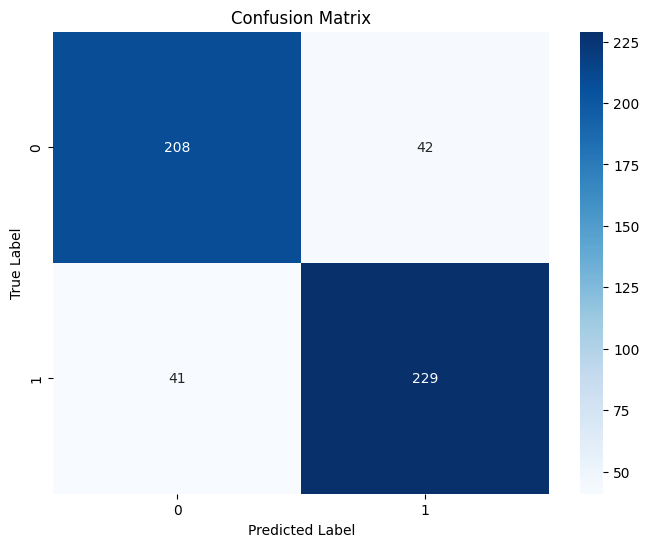

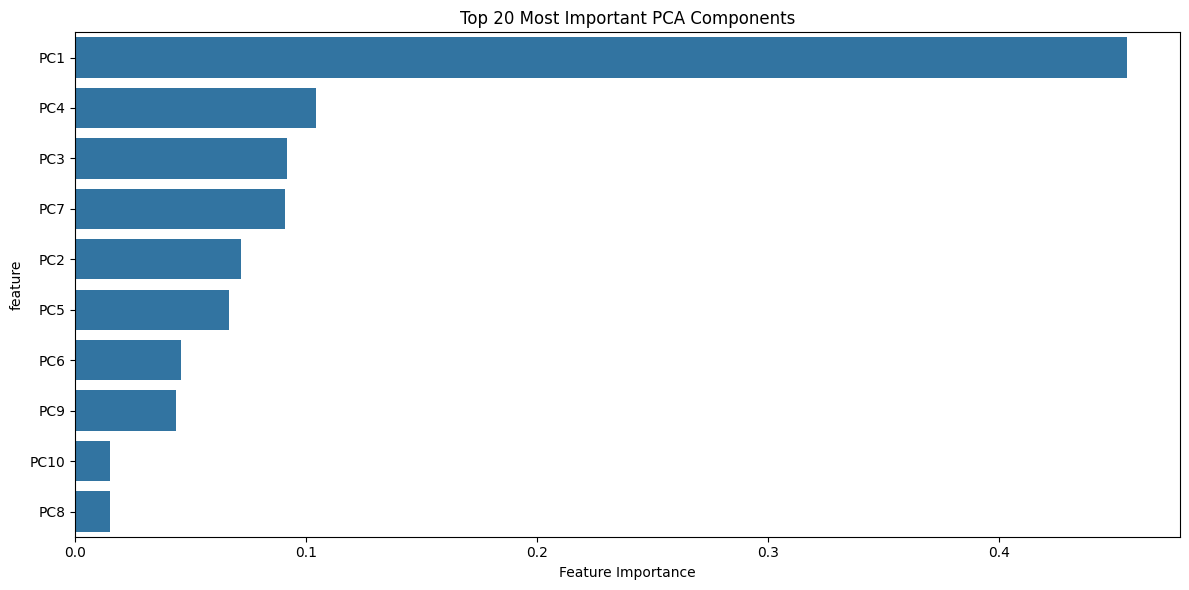

Successfully saved model at models/meta_models/tabnet_pca_model.zip

Prediction Statistics:
Number of predictions: 516
Distribution of predictions:
EventType
1    0.567829
0    0.432171
Name: proportion, dtype: float64


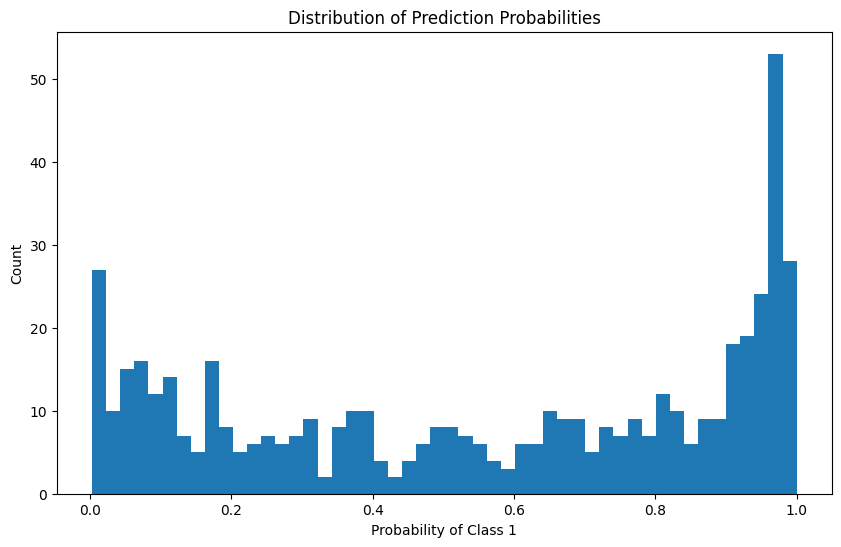

In [6]:

# Main execution pipeline
# 1. Prepare the training data
train_df = prepare_data(train_models, train_time_features)

# 2. Split into train and validation sets
train_data, val_data = split_data(train_df, val_size=0.2)

# 3. Apply PCA transformation
# You can specify n_components here, e.g., n_components=50
train_pca_df, pca_model, scaler = apply_pca_transform(train_data, n_components=10)
val_pca_df, _, _ = apply_pca_transform(val_data, pca_model=pca_model, scaler=scaler)

# 4. Train the model
model, feature_cols = train_tabnet_model(train_pca_df, val_pca_df)

# 5. Make predictions on validation set
X_val = val_pca_df[feature_cols].values.astype(np.float32)
y_val = val_pca_df['EventType'].values
val_preds = model.predict(X_val)
val_proba = model.predict_proba(X_val)

# 6. Evaluate the model
print("\nClassification Report:")
print(classification_report(y_val, val_preds))

# 7. Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, val_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 8. Plot feature importance of PCA components
plt.figure(figsize=(12, 6))
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

sns.barplot(data=feature_importance.head(20), x='importance', y='feature')
plt.title('Top 20 Most Important PCA Components')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

# 9. Create submission for test set
submission_df, test_proba = create_submission(
    test_models, 
    test_time_features, 
    model,
    pca_model,
    scaler
)

# 10. Save the submission
submission_df.to_csv('submission_tabnet_pca.csv', index=False)

# 11. Save the model and PCA transformer
model.save_model('models/meta_models/tabnet_pca_model')
np.save('models/meta_models/pca_model.npy', pca_model)
np.save('models/meta_models/scaler.npy', scaler)

# 12. Print predictions statistics
print("\nPrediction Statistics:")
print(f"Number of predictions: {len(submission_df)}")
print(f"Distribution of predictions:")
print(submission_df['EventType'].value_counts(normalize=True))

# 13. Plot probability distribution
plt.figure(figsize=(10, 6))
plt.hist(test_proba[:, 1], bins=50)
plt.title('Distribution of Prediction Probabilities')
plt.xlabel('Probability of Class 1')
plt.ylabel('Count')
plt.show()

In [7]:
submission_df

,ID,EventType
0,15_0,1
1,15_1,1
2,15_10,0
3,15_100,1
4,15_101,1
...,...,...
511,9_95,1
512,9_96,1
513,9_97,1
514,9_98,1


In [8]:
submission_df.to_csv('submission_tabnet_pca_82.csv', index=False)